<a href="https://colab.research.google.com/github/jacoponudo/Conversation_dynamics/blob/main/src/EDA/EDA_draw/48.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [2]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

fatal: destination path 'thesis' already exists and is not an empty directory.
Mounted at /content/drive


## Prepare Data

In [3]:
rd=pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_PRO.csv')

fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')

vo=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_PRO.csv')

gb=pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')


In [4]:
fb=filter_first_h(fb,100)

gb=filter_first_h(gb,100)

rd=filter_first_h(rd,100)

vo=filter_first_h(vo,100)

In [5]:
names = ['gb','rd','fb','vo']
datas = [gb,rd,fb,vo]

## Simulate synthetic data

100%|██████████| 4/4 [00:14<00:00,  3.61s/it]


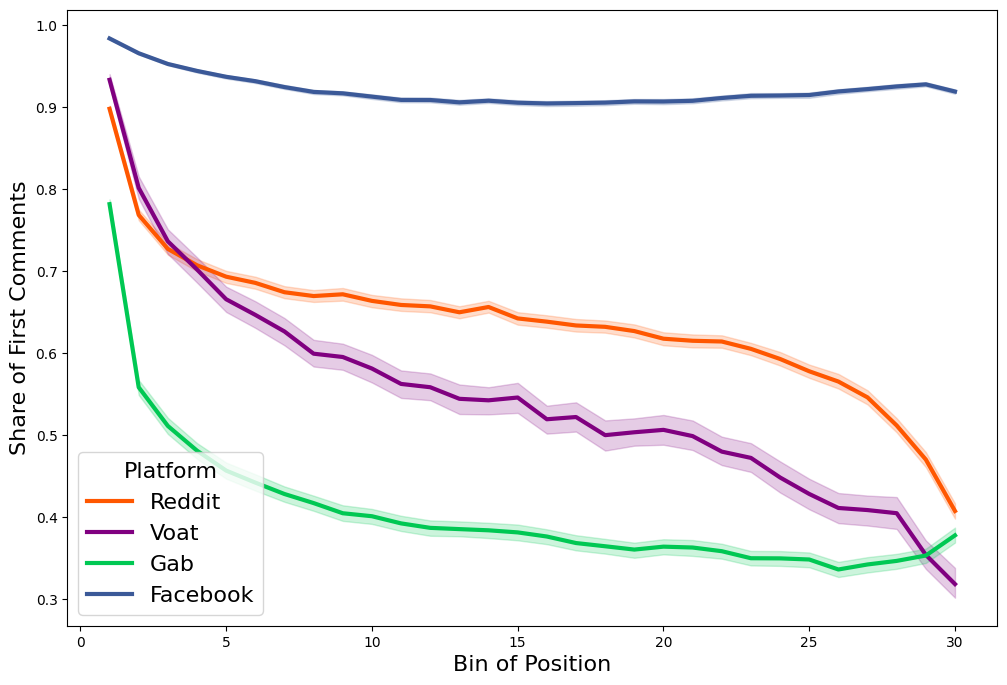

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Supponiamo che rdo_M1, voo_M1, fbo_M1, gbo_M1 siano i tuoi DataFrame

# Aggiungi la colonna 'platform' a ciascun DataFrame
rd['platform'] = 'Reddit'
vo['platform'] = 'Voat'
fb['platform'] = 'Facebook'
gb['platform'] = 'Gab'

# Combina tutti i DataFrame in un singolo DataFrame
all_data = []

# Processa ogni dataset individualmente
for df in tqdm([rd, vo, gb, fb]):
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df = df[df['number_of_comments'] > 50].copy()
    df['time'] = pd.to_datetime(df['temporal_distance_birth_base_100h'])
    df['sequential_position'] = df.groupby('post_id')['time'].rank(method='first')

    # Determina il numero di bins
    num_bins = 30

    # Calcola il bin di posizione
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    # Regola i bins per essere compresi tra 1 e num_bins
    df['bin_of_position'] = df['bin_of_position'].clip(lower=1, upper=num_bins)
    df['first_comment'] = df['sequential_number_of_comment_by_user_in_thread'] == 1

    # Raggruppa per 'bin_of_position', 'post_id', e calcola gli utenti unici per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)

all_data = pd.concat(all_data, ignore_index=True)

# Aggrega i dati attraverso tutti i dataset
agg_activity_obs = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()

# Definisci la palette personalizzata con i colori specificati
palette = {
    'Reddit': '#FF5700',   # Reddit orange
    'Voat': '#800080',     # Voat purple
    'Facebook': '#3b5998', # Facebook blue
    'Gab': '#00c853'       # Gab green
}

# Ordine desiderato delle piattaforme
platform_order = ['Reddit', 'Voat','Gab' ,'Facebook']

# Ordinamento del DataFrame
agg_activity_obs['platform'] = pd.Categorical(agg_activity_obs['platform'], categories=platform_order, ordered=True)
agg_activity_obs = agg_activity_obs.sort_values('platform')

# Crea il grafico
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Linea diversa per ciascuna piattaforma
    estimator='mean',  # o 'sum', 'median', ecc. a seconda della tua preferenza di aggregazione
    errorbar=('ci', 95),  # Intervallo di confidenza del 95%
    linewidth=3,
    palette=palette  # Palette personalizzata con i colori specificati
)

# Personalizza il titolo e le etichette con font-size 16
plt.ylabel('Share of First Comments', fontsize=16)
plt.xlabel('Bin of Position', fontsize=16)
plt.grid(False)
plt.legend(title='Platform', fontsize=16, title_fontsize=16)

# Mostra il grafico
plt.show()


Temporal dynamic

In [ ]:
time_intervals = np.arange(0, 1, 0.02)

names = ['gb','rd','fb','vo']
datas = [gb,rd,fb,vo]



all_dfs = []
for i, df in enumerate(datas):
    social = names[i]

    observed_t =df[['user_id', 'post_id', 'temporal_distance_birth_base_100h', 'sequential_number_of_comment_by_user_in_thread']]
    observed_t=observed_t[observed_t['post_id'].isin(observed_t['post_id'].sample(10000))]
    globals()[f"{social}o_M1"] = observed_t
    df_observed = pd.DataFrame(observed_t, columns=[f"{social}o_M1_col{i}" for i in range(observed_t.shape[1])])

    df_observed.to_csv(f"{social}o_M1.csv", index=False)


    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    all_dfs.append(observed_t_ECDF)

df_all_M1 = pd.concat(all_dfs, ignore_index=True)
df_all_M1['Time Grid Value']=df_all_M1['Time Grid Value']*100

Processing DataFrame:   2%|▏         | 183/7486 [00:09<05:07, 23.75it/s]

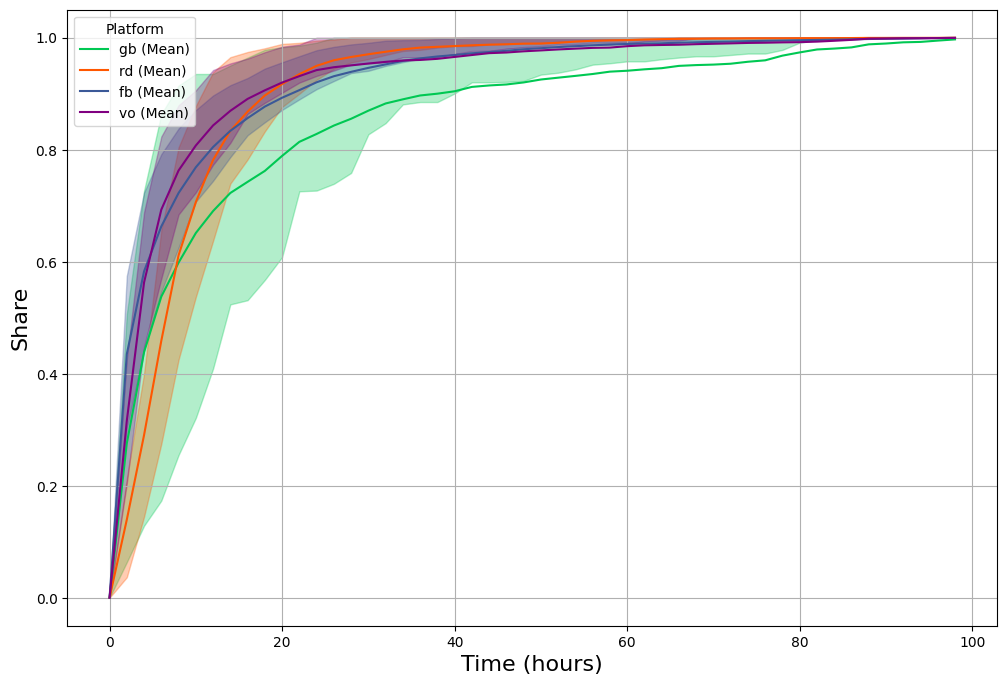

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Definire colori specifici per ogni piattaforma
colors = {
    'rd': '#FF5700',
    'vo': '#800080',
    'fb': '#3b5998',
    'gb': '#00c853'
}

# Funzione per calcolare i percentili
def calculate_percentiles(df):
    return df.groupby(['Platform', 'Time Grid Value']).agg(
        p20=('Share', lambda x: np.percentile(x, 20)),
        p80=('Share', lambda x: np.percentile(x, 80)),
        mean=('Share', 'mean')
    ).reset_index()

# Assicurati che df_all_M1 sia definito con i dati corretti
# Calcolare i percentili e la media
grouped = calculate_percentiles(df_all_M1)

# Ottenere piattaforme uniche
platforms = df_all_M1['Platform'].unique()

# Plot dei percentili e della media
plt.figure(figsize=(12, 8))

for platform in platforms:
    platform_data = grouped[grouped['Platform'] == platform]

    # Tracciare la linea della media
    plt.plot(platform_data['Time Grid Value'], platform_data['mean'],
              label=f'{platform} (Mean)',
              color=colors.get(platform,colors[str(platform)] ), linestyle='-')

    # Aggiungere poligoni tra i percentili
    plt.fill_between(platform_data['Time Grid Value'],
                      platform_data['p20'],
                      platform_data['p80'],
                      color=colors.get(platform, 'black'),
                      alpha=0.3)

# Aggiungere etichette e legenda
plt.ylabel('Share', fontsize=16)
plt.xlabel('Time (hours)', fontsize=16)
plt.grid(True)
plt.legend(title='Platform')
plt.show()


In [17]:
def calculate_ECDF(df, time_intervals, activate_tqdm=True):
    results_list = []
    df_c = df[df['sequential_number_of_comment_by_user_in_thread'] != 1]
    grouped = df.groupby('post_id')[['temporal_distance_birth_base_100h', 'sequential_number_of_comment_by_user_in_thread']]

    if activate_tqdm:
        grouped = tqdm(grouped, desc="Processing DataFrame")

    for post_id, group_data in grouped:
        results = pd.DataFrame(index=time_intervals)
        total_comments = len(group_data)

        for time in time_intervals:
            comments_within_time = np.sum(group_data['temporal_distance_birth_base_100h'] < time)
            comments_within_time_cc = np.sum(group_data[group_data['sequential_number_of_comment_by_user_in_thread'] != 1]['temporal_distance_birth_base_100h'] < time)

            share = comments_within_time / total_comments
            share_cc = comments_within_time_cc / total_comments

            results.at[time, 'Share'] = share
            results.at[time, 'Share_cc'] = share_cc

        results['post_id'] = post_id
        results = results.reset_index().rename(columns={'index': 'Time Grid Value'})
        results_list.append(results)

    final_results = pd.concat(results_list, ignore_index=True)

    return final_results